# Importing Libraries

In [ ]:
pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 22.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
import implicit
from sklearn.metrics import mean_squared_error
from implicit.als import AlternatingLeastSquares
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, Concatenate
import pandas as pd
import random
import scipy.sparse as sparse
import itertools




# Loading the Data

In [ ]:
train_data = np.load('ratings_train.npy')
test_data = np.load('ratings_test.npy')

print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")


Training Data Shape: (610, 4980)
Test Data Shape: (610, 4980)


# **ALS Based Collaborative Filtering**

### Processing Data

In [ ]:

train_data[np.isnan(train_data)] = 0
train_data_sparse = csr_matrix(train_data)
test_data[np.isnan(test_data)] = 0
test_data_sparse = csr_matrix(test_data)


In [ ]:
train_data_sparse

<610x4980 sparse matrix of type '<class 'numpy.float64'>'
	with 31598 stored elements in Compressed Sparse Row format>

### Hyper Parameter Tuning

#### Data Splitting

In [ ]:


def train_val_split(train_data_sparse, val_fraction=0.1, random_seed=42):
    """
    Split the given train matrix into training and validation matrices by masking some entries.

    Args:
    - train_data_sparse: The original sparse training matrix.
    - val_fraction: Fraction of entries to mask for validation.
    - random_seed: Random seed for reproducibility.

    Returns:
    - train_data_new: Training matrix with some entries removed.
    - val_data: Validation matrix with the removed entries.
    """
    random.seed(random_seed)

    # Create validation matrix as a copy of train_data
    val_data = sparse.lil_matrix(train_data_sparse.shape)

    # Get the non-zero entries of the train matrix
    user_indices, item_indices = train_data_sparse.nonzero()
    non_zero_entries = list(zip(user_indices, item_indices))

    # Shuffle and select a subset of these entries for validation
    num_val = int(len(non_zero_entries) * val_fraction)
    val_indices = random.sample(non_zero_entries, num_val)

    # Mask selected entries from training and move them to validation
    train_data_new = train_data_sparse.copy().tolil()  # Use lil_matrix for efficient assignment
    for user, item in val_indices:
        val_data[user, item] = train_data_new[user, item]  # Move to validation set
        train_data_new[user, item] = 0  # Remove from training set

    return train_data_new.tocsr(), val_data.tocsr()

# Perform the train-validation split
train_data_sparse, val_data_sparse = train_val_split(train_data_sparse, val_fraction=0.1)

# Check the shapes and some properties of the new train and val matrices
print(f"Training Data Shape: {train_data_sparse.shape}")
print(f"Validation Data Shape: {val_data_sparse.shape}")


Training Data Shape: (610, 4980)
Validation Data Shape: (610, 4980)


In [ ]:
val_data_numpy = val_data_sparse.toarray() #converting validation data to array

#### Defining model evaluation function

In [ ]:
# Define a function to evaluate model performance
def evaluate_model(model, user_matrix, item_matrix, test_matrix):
    prediction_matrix = np.matmul(user_matrix, item_matrix.T)
    predictions, actuals = [], []

    num_users, num_items = test_matrix.shape
    for user_id in range(num_users):
        user_items = test_matrix[user_id]
        known_indices = np.where(user_items > 0)[0]
        for item_id in known_indices:
            predicted_value = prediction_matrix[user_id, item_id]
            predictions.append(predicted_value)
            actuals.append(user_items[item_id])

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    return mse, rmse


#### Tuning Process

In [ ]:
# Hyperparameter grid
factors_range = [10, 50, 80,100]
regularization_range = [0.001,0.01, 0.1, 1]
iterations_range = [10, 25, 50,100]

best_rmse = float('inf')
best_params = {}

# Grid search for hyperparameter tuning
for factors, regularization, iterations in itertools.product(factors_range, regularization_range, iterations_range):
    # Build and train the ALS model
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
    model.fit(train_data_sparse)

    # Get the user and item matrices
    user_matrix = model.user_factors
    item_matrix = model.item_factors

    # Evaluate the model
    mse, rmse = evaluate_model(model, user_matrix, item_matrix, val_data_numpy)

    # Print results for this combination of hyperparameters
    print(f"factors: {factors}, regularization: {regularization}, iterations: {iterations} --> RMSE: {rmse}")

    # Track the best hyperparameters
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'factors': factors, 'regularization': regularization, 'iterations': iterations}

# Print the best hyperparameters
print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 10, regularization: 0.001, iterations: 10 --> RMSE: 3.4690652487603164


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 10, regularization: 0.001, iterations: 25 --> RMSE: 3.4683437263076993


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 10, regularization: 0.001, iterations: 50 --> RMSE: 3.4673219342956845


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 10, regularization: 0.001, iterations: 100 --> RMSE: 3.4656138374528767


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 10, regularization: 0.01, iterations: 10 --> RMSE: 3.4700467035903895


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 10, regularization: 0.01, iterations: 25 --> RMSE: 3.467222625060915


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 10, regularization: 0.01, iterations: 50 --> RMSE: 3.465485198609964


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 10, regularization: 0.01, iterations: 100 --> RMSE: 3.465491272105625


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 10, regularization: 0.1, iterations: 10 --> RMSE: 3.4701593486429823


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 10, regularization: 0.1, iterations: 25 --> RMSE: 3.468265094502995


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 10, regularization: 0.1, iterations: 50 --> RMSE: 3.468103215699793


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 10, regularization: 0.1, iterations: 100 --> RMSE: 3.4652797993848607


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 10, regularization: 1, iterations: 10 --> RMSE: 3.477189051006936


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 10, regularization: 1, iterations: 25 --> RMSE: 3.4688097393328134


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 10, regularization: 1, iterations: 50 --> RMSE: 3.469770713402227


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 10, regularization: 1, iterations: 100 --> RMSE: 3.467923335783614


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 50, regularization: 0.001, iterations: 10 --> RMSE: 3.533657130919359


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 50, regularization: 0.001, iterations: 25 --> RMSE: 3.534893806095788


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 50, regularization: 0.001, iterations: 50 --> RMSE: 3.5364311080606683


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 50, regularization: 0.001, iterations: 100 --> RMSE: 3.5362967703055395


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 50, regularization: 0.01, iterations: 10 --> RMSE: 3.534204865502027


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 50, regularization: 0.01, iterations: 25 --> RMSE: 3.535638911590191


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 50, regularization: 0.01, iterations: 50 --> RMSE: 3.5378919401192466


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 50, regularization: 0.01, iterations: 100 --> RMSE: 3.5353996144370243


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 50, regularization: 0.1, iterations: 10 --> RMSE: 3.5373005704792337


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 50, regularization: 0.1, iterations: 25 --> RMSE: 3.5387432332376454


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 50, regularization: 0.1, iterations: 50 --> RMSE: 3.5379012023880834


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 50, regularization: 0.1, iterations: 100 --> RMSE: 3.53670367991787


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 50, regularization: 1, iterations: 10 --> RMSE: 3.5376638288349986


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 50, regularization: 1, iterations: 25 --> RMSE: 3.533926218765509


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 50, regularization: 1, iterations: 50 --> RMSE: 3.5375558190347283


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 50, regularization: 1, iterations: 100 --> RMSE: 3.5363877107093327


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 80, regularization: 0.001, iterations: 10 --> RMSE: 3.5690495476221193


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 80, regularization: 0.001, iterations: 25 --> RMSE: 3.5680897625368835


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 80, regularization: 0.001, iterations: 50 --> RMSE: 3.5694179976366525


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 80, regularization: 0.001, iterations: 100 --> RMSE: 3.56981784309736


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 80, regularization: 0.01, iterations: 10 --> RMSE: 3.5712171134050177


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 80, regularization: 0.01, iterations: 25 --> RMSE: 3.56837742693588


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 80, regularization: 0.01, iterations: 50 --> RMSE: 3.56918411589688


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 80, regularization: 0.01, iterations: 100 --> RMSE: 3.5703165968923893


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 80, regularization: 0.1, iterations: 10 --> RMSE: 3.5704822720989653


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 80, regularization: 0.1, iterations: 25 --> RMSE: 3.570307579371472


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 80, regularization: 0.1, iterations: 50 --> RMSE: 3.570552740102351


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 80, regularization: 0.1, iterations: 100 --> RMSE: 3.569601732039793


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 80, regularization: 1, iterations: 10 --> RMSE: 3.565741785394999


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 80, regularization: 1, iterations: 25 --> RMSE: 3.567611961850602


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 80, regularization: 1, iterations: 50 --> RMSE: 3.568921128096107


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 80, regularization: 1, iterations: 100 --> RMSE: 3.569140864213538


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 100, regularization: 0.001, iterations: 10 --> RMSE: 3.587405808399659


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 100, regularization: 0.001, iterations: 25 --> RMSE: 3.5838642717375833


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 100, regularization: 0.001, iterations: 50 --> RMSE: 3.5834647385737406


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 100, regularization: 0.001, iterations: 100 --> RMSE: 3.584288902525387


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 100, regularization: 0.01, iterations: 10 --> RMSE: 3.5850265794877747


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 100, regularization: 0.01, iterations: 25 --> RMSE: 3.5835337010517634


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 100, regularization: 0.01, iterations: 50 --> RMSE: 3.5839154906643094


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 100, regularization: 0.01, iterations: 100 --> RMSE: 3.5842742483520404


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 100, regularization: 0.1, iterations: 10 --> RMSE: 3.587012944140137


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 100, regularization: 0.1, iterations: 25 --> RMSE: 3.58500909187649


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 100, regularization: 0.1, iterations: 50 --> RMSE: 3.584522483645907


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 100, regularization: 0.1, iterations: 100 --> RMSE: 3.5846116080022146


  0%|          | 0/10 [00:00<?, ?it/s]

factors: 100, regularization: 1, iterations: 10 --> RMSE: 3.5800304752382996


  0%|          | 0/25 [00:00<?, ?it/s]

factors: 100, regularization: 1, iterations: 25 --> RMSE: 3.5821988480542917


  0%|          | 0/50 [00:00<?, ?it/s]

factors: 100, regularization: 1, iterations: 50 --> RMSE: 3.583622725272239


  0%|          | 0/100 [00:00<?, ?it/s]

factors: 100, regularization: 1, iterations: 100 --> RMSE: 3.582719308252138
Best RMSE: 3.4652797993848607
Best Parameters: {'factors': 10, 'regularization': 0.1, 'iterations': 100}


### Training

In [ ]:

model = implicit.als.AlternatingLeastSquares(factors=10, regularization=0.1, iterations=100)
model.fit(train_data_sparse)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
user_matrix = model.user_factors
item_matrix = model.item_factors

# Print the matrices
print("User Matrix:")
print(user_matrix.shape)

print("Item Matrix:")
print(item_matrix.shape)

User Matrix:
(610, 10)
Item Matrix:
(4980, 10)


### Prediction and Evluation


In [ ]:
predicted_ratings = np.matmul(user_matrix, item_matrix.T)

In [ ]:
def evaluation(model, user_matrix, item_matrix,test_matrix):
    prediction_matrix = np.matmul(user_matrix, item_matrix.T)
    predictions = []
    actuals = []
    num_users, num_items = test_matrix.shape
    for user_id in range(num_users):
        user_items = test_matrix[user_id]
        known_indices = np.where(user_items > 0)[0]
        for item_id in known_indices:
            predicted_value = prediction_matrix[user_id,item_id]
            predictions.append(predicted_value)
            actuals.append(user_items[item_id])
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    return mse, rmse





In [ ]:
mse,rmse=evaluation(model, user_matrix, item_matrix,test_data)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 12.045774102324366
Root Mean Squared Error: 3.470702249160012


### Learning Curve

In [ ]:
test_data[1]

array([0., 0., 0., ..., 0., 0., 0.])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

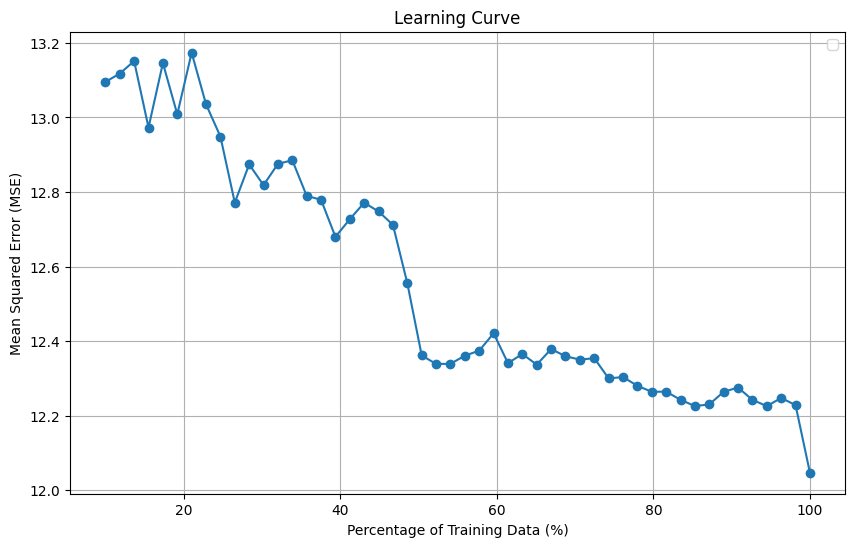

In [ ]:

training_sizes = np.linspace(0.1, 1.0, 50)
train_mse = []
train_rmse = []
for size in training_sizes:

    train_size = int(size * train_data_sparse.shape[0])
    train_set = train_data_sparse[:train_size]
    test_set = test_data[:train_size]


    model = AlternatingLeastSquares(factors=10, regularization=0.01,iterations=50)
    model.fit(train_set)
    user_matrix = model.user_factors
    item_matrix = model.item_factors
    mse, rmse = evaluation(model, user_matrix, item_matrix, test_set)
    train_mse.append(mse)
    train_rmse.append(rmse)


# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(training_sizes * 100, train_mse, marker='o')
plt.title('Learning Curve')
plt.xlabel('Percentage of Training Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid()
plt.legend()
plt.show()
